In [3]:
import pandas as pd
import numpy as np
from scipy.stats import uniform, norm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
df = pd.read_csv('data-p2/encoded_filtered_mimic3d.csv')  
X = df.drop('LOSdays', axis=1).values
y = df['LOSdays'].values

In [5]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")  # Should be (n_samples,)

X shape: (2976, 103)
y shape: (2976,)


In [6]:
def likehd(params, X, y):
    a = np.array(params[:-2])  
    b = params[-2]  
    sd = params[-1]

    pred = np.dot(X, a) + b

    single_likelihoods = norm.logpdf(y, loc=pred, scale=sd)

    return np.sum(single_likelihoods)

In [7]:
def prior(params, t_A, t_B, t_sd):
    
    coefficients = params[:-2]  
    intercept = params[-2]  
    sd = params[-1]  

    a_priors = norm.logpdf(intercept, loc=t_A, scale=5) # switch to laplace

    b_prior = norm.logpdf(intercept, loc=t_B, scale=5)
    sd_prior = uniform.logpdf(sd, loc=0, scale=2 * t_sd)
    
    return a_priors + b_prior + sd_prior

In [8]:
def posterior(params, X, y, t_A, t_B, t_sd):
    log_likelihood = likehd(params, X, y)
    log_prior = prior(params, t_A, t_B, t_sd)
    
    return log_likelihood + log_prior


In [9]:
def proposal_function(params):
    return np.random.normal(loc=params, scale=np.array([0.1] * len(params)))

def run_metropolis_MCMC(start_value, iterations, X, y, t_A, t_B, t_sd):
    chain = np.zeros((iterations + 1, len(start_value)))  # Initialize chain
    chain[0, :] = start_value  # Set initial parameters

    for i in range(iterations):
        proposal = proposal_function(chain[i, :])  
        probab = np.exp(
            posterior(proposal, X, y, t_A, t_B, t_sd) - posterior(chain[i, :], X, y, t_A, t_B, t_sd)
        )

        if np.random.rand() < probab:
            chain[i + 1, :] = proposal  
        else:
            chain[i + 1, :] = chain[i, :]  

    return chain


In [10]:
num_predictors = 103  # Number of predictors
start_value = np.random.rand(num_predictors + 2) 
t_A = 1.5  
t_B = 0.0  
t_sd = 0.5  

start_value = np.random.rand(103 + 2)

chain = run_metropolis_MCMC(start_value, 10, X, y, t_A, t_B, t_sd)

print(chain[:5, :])

NameError: name 'laplace' is not defined

In [47]:
def calculate_acceptance_rate(chain, burn_in):
    post_burn_in_chain = chain[burn_in:]

    acceptance_rate = 1 - np.mean(np.all(np.diff(post_burn_in_chain, axis=0) == 0, axis=1))

    return acceptance_rate


In [48]:
burn_in = 5 
acceptance_rate = calculate_acceptance_rate(chain, burn_in)

print(f'Acceptance Rate: {acceptance_rate:.4f}')


Acceptance Rate: 0.2000


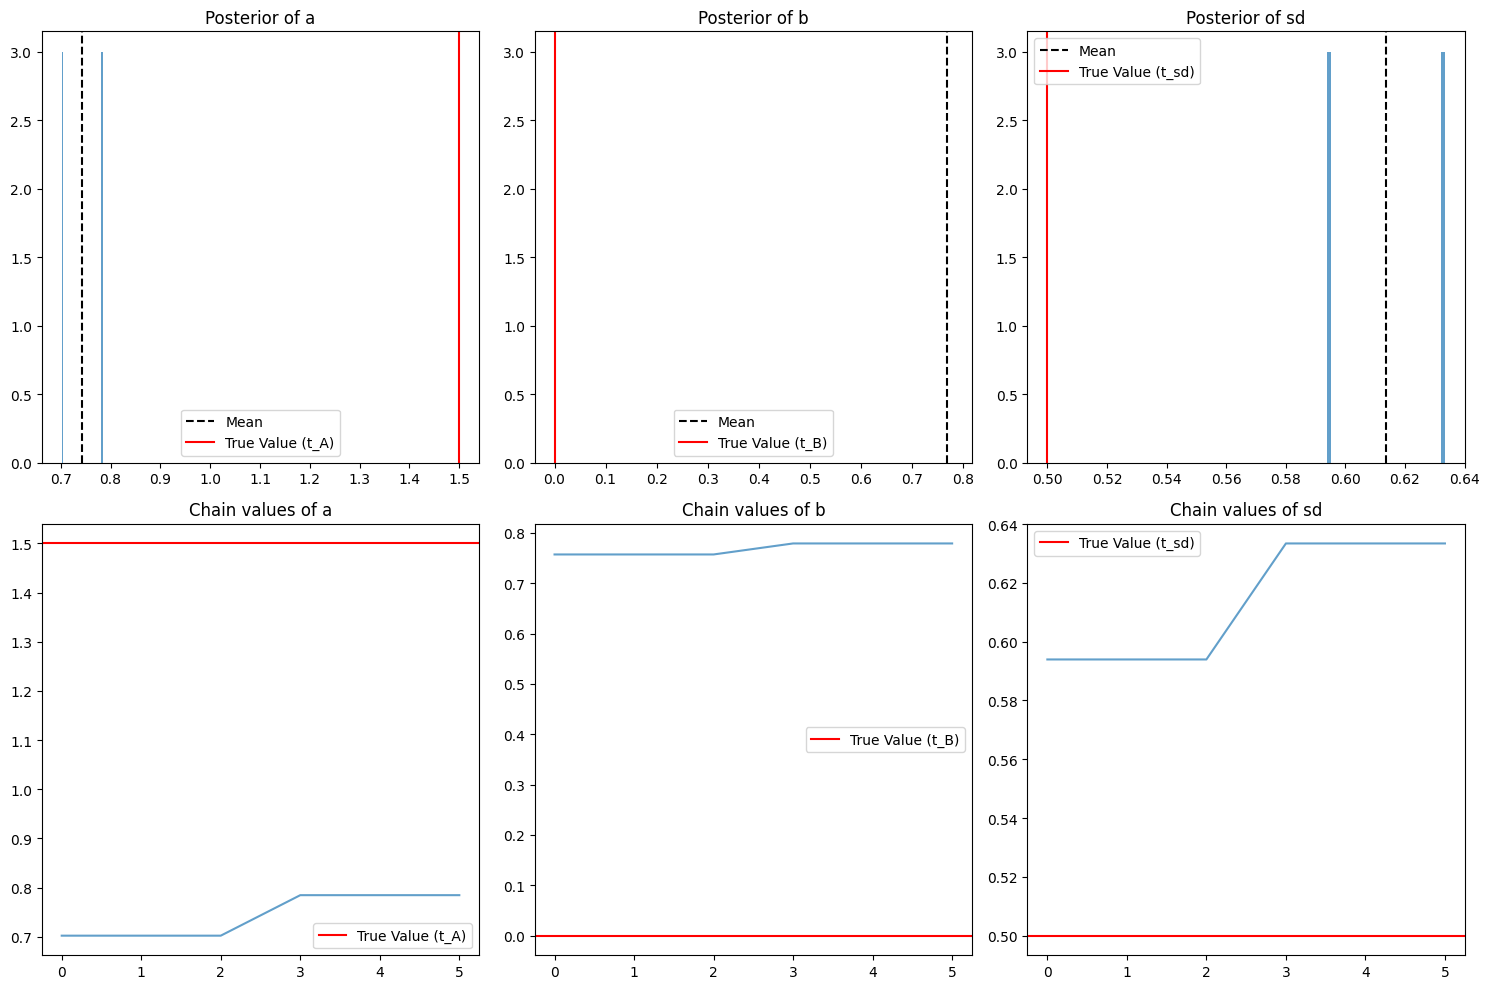

In [49]:

post_burn_in_chain = chain[burn_in:]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes[0, 0].hist(post_burn_in_chain[:, 0], bins=30, alpha=0.7)
axes[0, 0].axvline(np.mean(post_burn_in_chain[:, 0]), color='black', linestyle='--', label='Mean')
axes[0, 0].axvline(t_A, color='red', linestyle='-', label='True Value (t_A)')
axes[0, 0].set_title("Posterior of a")
axes[0, 0].legend()

axes[0, 1].hist(post_burn_in_chain[:, 1], bins=30, alpha=0.7)
axes[0, 1].axvline(np.mean(post_burn_in_chain[:, 1]), color='black', linestyle='--', label='Mean')
axes[0, 1].axvline(t_B, color='red', linestyle='-', label='True Value (t_B)')
axes[0, 1].set_title("Posterior of b")
axes[0, 1].legend()


axes[0, 2].hist(post_burn_in_chain[:, 2], bins=30, alpha=0.7)
axes[0, 2].axvline(np.mean(post_burn_in_chain[:, 2]), color='black', linestyle='--', label='Mean')
axes[0, 2].axvline(t_sd, color='red', linestyle='-', label='True Value (t_sd)')
axes[0, 2].set_title("Posterior of sd")
axes[0, 2].legend()

axes[1, 0].plot(post_burn_in_chain[:, 0], alpha=0.7)
axes[1, 0].axhline(t_A, color='red', linestyle='-', label='True Value (t_A)')
axes[1, 0].set_title("Chain values of a")
axes[1, 0].legend()

axes[1, 1].plot(post_burn_in_chain[:, 1], alpha=0.7)
axes[1, 1].axhline(t_B, color='red', linestyle='-', label='True Value (t_B)')
axes[1, 1].set_title("Chain values of b")
axes[1, 1].legend()

axes[1, 2].plot(post_burn_in_chain[:, 2], alpha=0.7)
axes[1, 2].axhline(t_sd, color='red', linestyle='-', label='True Value (t_sd)')
axes[1, 2].set_title("Chain values of sd")
axes[1, 2].legend()

plt.tight_layout()
plt.show()


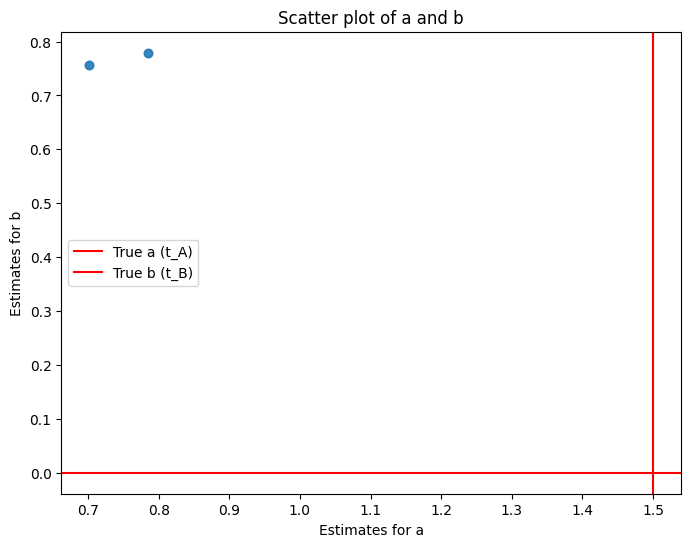

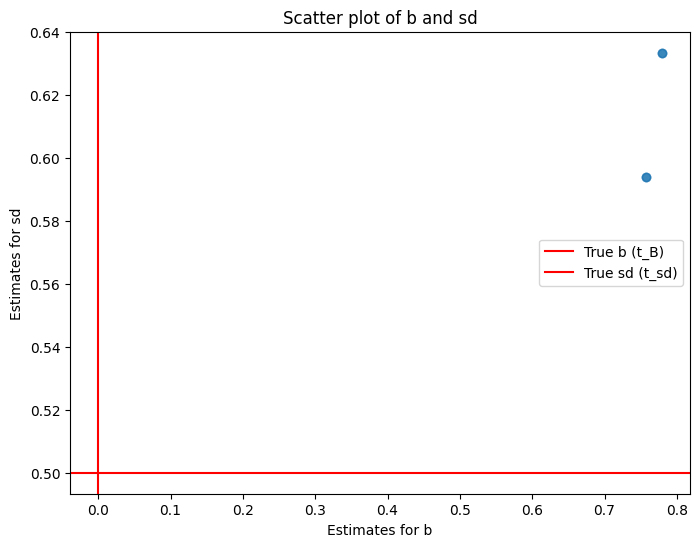

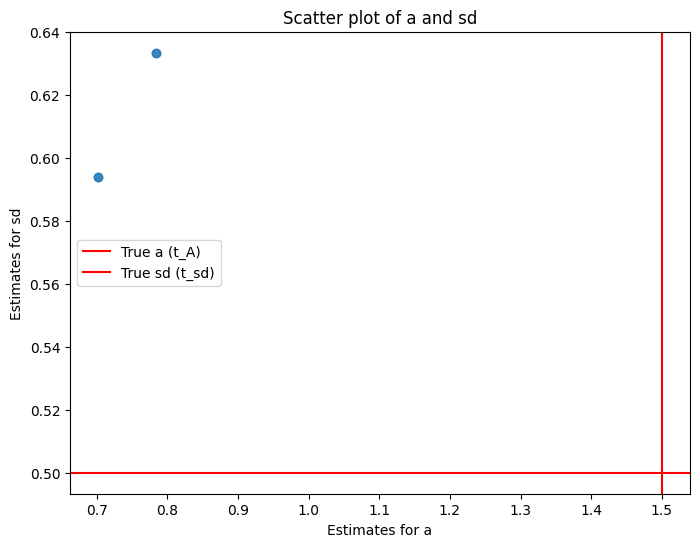

In [50]:
plt.figure(figsize=(8, 6))
plt.scatter(post_burn_in_chain[:, 0], post_burn_in_chain[:, 1], alpha=0.5)
plt.axvline(t_A, color='red', linestyle='-', label='True a (t_A)')
plt.axhline(t_B, color='red', linestyle='-', label='True b (t_B)')
plt.title("Scatter plot of a and b")
plt.xlabel("Estimates for a")
plt.ylabel("Estimates for b")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(post_burn_in_chain[:, 1], post_burn_in_chain[:, 2], alpha=0.5)
plt.axvline(t_B, color='red', linestyle='-', label='True b (t_B)')
plt.axhline(t_sd, color='red', linestyle='-', label='True sd (t_sd)')
plt.title("Scatter plot of b and sd")
plt.xlabel("Estimates for b")
plt.ylabel("Estimates for sd")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(post_burn_in_chain[:, 0], post_burn_in_chain[:, 2], alpha=0.5)
plt.axvline(t_A, color='red', linestyle='-', label='True a (t_A)')
plt.axhline(t_sd, color='red', linestyle='-', label='True sd (t_sd)')
plt.title("Scatter plot of a and sd")
plt.xlabel("Estimates for a")
plt.ylabel("Estimates for sd")
plt.legend()
plt.show()

In [40]:
model = LinearRegression()

model.fit(X, y)

y_pred = model.predict(X)

print(f"Intercept: {model.intercept_}")
print(f"Coefficients: {model.coef_}")

r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print(f"R² score: {r2}")
print(f"Mean Squared Error: {mse}")

Intercept: -8.261179067560818
Coefficients: [-1.73162405e-02 -1.78496913e-01  3.96598033e-02 -1.05959936e-01
  2.99198972e-01  2.84715238e-02  1.89336927e-02  2.57753439e-02
  2.50931428e-02 -1.74382750e-02 -2.88267337e-02  3.84783151e-02
 -1.81113435e-01  1.82309184e-02  1.51798095e+00 -1.79935812e-02
  6.98992711e+00  2.75004975e-01 -1.78125828e+00  1.11620803e+00
 -1.85806425e+00  4.09755559e+00  4.02262648e+00  3.32648347e+00
  2.34547323e+00  4.63057358e+00  9.41799193e+00  9.33112808e+00
  3.62524884e-01 -2.13412790e-01  1.38091403e+00  2.88593210e+00
  1.64942100e+00 -3.89116000e-01  1.05403304e-01  1.52353103e+00
  1.48335422e+00 -1.72311164e-01  2.47382069e+00  7.72429434e-01
  2.05267591e+00 -1.16655971e+00  1.67091878e+00  1.20732268e+00
  2.56055015e-02  1.04408632e+00 -4.46155978e-01  3.27449820e-01
 -1.72571751e+00  2.17666916e-01 -9.60616798e-01  1.16378869e+00
  1.69939826e+00  1.78041642e+01  5.04929990e+01  1.86830443e+00
 -7.81079658e-01  2.40759618e-01  8.31207966e+

In [41]:
from sklearn.feature_selection import VarianceThreshold

In [42]:
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
sel.fit_transform(X)

array([[59, 2.23, 0.99, ..., 0, 0, 1],
       [21, 0.97, 1.04, ..., 0, 1, 0],
       [82, 1.69, 0.3, ..., 0, 1, 1],
       ...,
       [77, 2.74, 0.63, ..., 1, 0, 0],
       [40, 1.2, 0.4, ..., 0, 0, 1],
       [62, 2.74, 0.48, ..., 0, 0, 0]], dtype=object)